# Call center simulation

We simulate a simplified call center, operating with one queue and several agents.

Customers have a patience threshold, after which the abandon.

We rely on the discrete event library *ConcurrentSim*, that itself uses *ResumableFunctions*, allowing to put a function on pause until an event is catched.

In [4]:
using ConcurrentSim
using ResumableFunctions
using Random
using Statistics
using Printf
using Plots

## Call center structure

In [5]:
# ----------------------------
# Statistics struct
# ----------------------------
mutable struct CallCenterStats
    total_calls::Int
    answered_calls::Int
    abandoned_calls::Int
    wait_times::Vector{Float64}
    service_times::Vector{Float64}
    queue_history::Vector{Tuple{Float64, Int}}   # (time, queue_length)
    busy_history::Vector{Tuple{Float64, Int}}    # (time, busy_agents)
    events::Vector{Tuple{Float64, Int, Symbol}}  # (time, customer_id, event_type)
    active_customers::Int
    arrivals_stopped::Bool
    start_time::Float64
    end_time::Float64
end

function CallCenterStats()
    CallCenterStats(0,0,0,Float64[],Float64[],
                   Tuple{Float64,Int}[], Tuple{Float64,Int}[],
                   Tuple{Float64,Int,Symbol}[], 0, false, 0.0, 0.0)
end

CallCenterStats

## Call arrivals

In [6]:
# ----------------------------
# Call generator (arrivals)
# ----------------------------
@resumable function call_generator(env::Environment, agents::Resource,
                                   stats::CallCenterStats, mean_interarrival::Float64,
                                   max_wait::Float64, mean_service::Float64,
                                   rng::Xoshiro, sim_time::Float64)

    id = 1
    while now(env) < sim_time
        # exponential interarrival
        interarrival = -log(rand(rng)) * mean_interarrival
        @yield timeout(env, interarrival)

        # schedule arrival if still within sim_time
        if now(env) < sim_time
            @process customer(env, id, agents, stats, max_wait, mean_service, rng)
            id += 1
        end
    end

    # mark arrivals stopped; monitor will detect emptiness and set end_time
    stats.arrivals_stopped = true
    println(@sprintf("[%.2f] Arrivals stopped. Waiting for system to empty...", now(env)))
end

call_generator (generic function with 1 method)

## Customer

In [7]:
# ----------------------------
# Customer process (hard max-wait)
# ----------------------------
@resumable function customer(env::Environment, id::Int, agents::Resource,
                             stats::CallCenterStats, max_wait::Float64,
                             mean_service::Float64, rng::Xoshiro)

    arrival = now(env)
    # record start_time at first arrival
    if stats.start_time == 0.0
        stats.start_time = arrival
    end

    stats.total_calls += 1
    stats.active_customers += 1
    push!(stats.events, (arrival, id, :arrival))

    # Request an agent (this will be granted when available)
    req = request(agents)

    # Wait until resource is granted (blocks)
    @yield req

    # Now compute actual wait time
    wait_time = now(env) - arrival

    if wait_time >= max_wait
        # Hard abandonment: customer gives up even though an agent became available
        stats.abandoned_calls += 1
        push!(stats.events, (now(env), id, :abandoned))

        # Immediately free the agent that was just granted
        # release returns capacity to the pool
        @yield release(agents)

        # do NOT perform service
    else
        # Customer is served
        stats.answered_calls += 1
        push!(stats.wait_times, wait_time)
        push!(stats.events, (now(env), id, :served))

        # Service time (exponential with mean mean_service)
        service_time = -log(rand(rng)) * mean_service
        push!(stats.service_times, service_time)

        # perform service
        @yield timeout(env, service_time)

        # mark completed event and free agent
        push!(stats.events, (now(env), id, :completed))
        @yield release(agents)
    end

    stats.active_customers -= 1
end

customer (generic function with 1 method)

## Queue

In [8]:
# ----------------------------
# Helper: find queue length at or before time t
# ----------------------------
function queue_length_at(stats::CallCenterStats, t::Float64)
    if isempty(stats.queue_history)
        return 0
    end
    # find last record with time <= t
    idx = findlast(x -> x[1] <= t, stats.queue_history)
    return idx === nothing ? 0 : stats.queue_history[idx][2]
end

queue_length_at (generic function with 1 method)

## Simulation monitoring

We stop the simulation when all the clients have left the system and no additional arrival is permitted.

In [10]:
# ----------------------------
# Monitor process (runs throughout)
# ----------------------------
@resumable function monitor(env::Environment, agents::Resource,
                            stats::CallCenterStats, interval::Float64)

    while true
        # sample at regular intervals
        @yield timeout(env, interval)
        push!(stats.queue_history, (now(env), length(agents.put_queue)))
        push!(stats.busy_history, (now(env), agents.level))

        # If arrivals have stopped and no active customers, simulation is finished
        if stats.arrivals_stopped && stats.active_customers == 0
            stats.end_time = now(env)
            println(@sprintf("[%.2f] All customers served/abandoned. Simulation complete.", stats.end_time))
            break
        end
    end
end


monitor (generic function with 1 method)

## Visualization methods

In [11]:
# ----------------------------
# Plotting: queue + events + utilization + histograms
# ----------------------------
function plot_results(stats::CallCenterStats, num_agents::Int)
    # If no start_time or end_time were recorded, fall back to sensible bounds
    if stats.start_time == 0.0
        xmin = 0.0
    else
        xmin = stats.start_time
    end
    if stats.end_time == 0.0
        # no end recorded (shouldn't happen when using run(sim)); use last sample
        xmax = isempty(stats.queue_history) ? xmin + 1.0 : maximum(t[1] for t in stats.queue_history)
    else
        xmax = stats.end_time
    end

    # Collect queue history within [xmin, xmax]
    qtimes = [t[1] for t in stats.queue_history if t[1] >= xmin && t[1] <= xmax]
    qlens  = [t[2] for t in stats.queue_history if t[1] >= xmin && t[1] <= xmax]

    # Base queue plot
    p1 = plot(title="Queue Length Over Time", xlabel="Time (min)", ylabel="Queue Length",
              legend=true, linewidth=2, xlims=(xmin, xmax))
    if !isempty(qtimes)
        plot!(p1, qtimes, qlens, label="Queue length", color=:orange)
    end

    # overlay events: served, abandoned, completed
    served_times = [t[1] for t in stats.events if t[3] == :served && t[1] >= xmin && t[1] <= xmax]
    abandoned_times = [t[1] for t in stats.events if t[3] == :abandoned && t[1] >= xmin && t[1] <= xmax]
    completed_times = [t[1] for t in stats.events if t[3] == :completed && t[1] >= xmin && t[1] <= xmax]

    # get y-values for markers using queue length at that time (or 0 fallback)
    served_y = [queue_length_at(stats, tt) for tt in served_times]
    abandoned_y = [queue_length_at(stats, tt) for tt in abandoned_times]
    completed_y = [queue_length_at(stats, tt) for tt in completed_times]

    if !isempty(served_times)
        scatter!(p1, served_times, served_y, marker=:circle, ms=6, color=:green, label="Served")
    end
    if !isempty(abandoned_times)
        scatter!(p1, abandoned_times, abandoned_y, marker=:x, ms=8, color=:red, label="Abandoned")
    end
    if !isempty(completed_times)
        scatter!(p1, completed_times, completed_y, marker=:diamond, ms=5, color=:blue, label="Completed")
    end

    # Agent utilization plot
    btimes = [t[1] for t in stats.busy_history if t[1] >= xmin && t[1] <= xmax]
    busy   = [t[2] for t in stats.busy_history if t[1] >= xmin && t[1] <= xmax]
    p2 = plot(title="Agent Utilization Over Time", xlabel="Time (min)", ylabel="Busy Agents",
              legend=false, linewidth=2, xlims=(xmin, xmax), ylims=(0, num_agents + 0.5))
    if !isempty(btimes)
        plot!(p2, btimes, busy, label="Busy agents", color=:purple)
        hline!(p2, [num_agents], linestyle=:dash, color=:red, label="Capacity")
    end

    # Outcomes bar
    p3 = bar(["Answered","Abandoned"], [stats.answered_calls, stats.abandoned_calls],
             title="Call Outcomes", ylabel="Count", legend=false, color=[:green, :red], alpha=0.8)

    # Wait-time histogram
    p4 = histogram(stats.wait_times, bins=20, title="Wait Time Distribution (served)",
                   xlabel="Wait (min)", ylabel="Frequency", legend=false)

    plot(p1, p2, p3, p4, layout = (2,2), size=(1100,800))
end

plot_results (generic function with 1 method)

## Simulation run

In [13]:
# ----------------------------
# Run the full simulation
# ----------------------------
function run_call_center_simulation(; num_agents::Int=3,
                                   sim_time::Float64=60.0,
                                   mean_interarrival::Float64=1.8,
                                   mean_service::Float64=5.0,
                                   max_wait::Float64=4.0,
                                   rng_seed::Int=123)

    println("=== Call Center Simulation ===")
    println("agents: $num_agents, sim_time: $sim_time, mean_interarrival: $mean_interarrival, mean_service: $mean_service, max_wait: $max_wait\n")

    sim = Simulation()
    rng = Xoshiro(rng_seed)

    agents = Resource(sim, num_agents)
    stats = CallCenterStats()

    # Schedule monitor first so it samples throughout
    @process monitor(sim, agents, stats, 0.5)
    @process call_generator(sim, agents, stats, mean_interarrival, max_wait, mean_service, rng, sim_time)

    # Run until no events remain (ensures system empties)
    run(sim)   # <--- important: run until scheduler empty

    # Print summary
    println("\n=== Simulation Results ===")
    println(@sprintf("Actual start time: %.2f", stats.start_time))
    println(@sprintf("Actual end time:   %.2f", stats.end_time))
    println(@sprintf("Total calls:       %d", stats.total_calls))
    println(@sprintf("Answered calls:    %d (%.1f%%)", stats.answered_calls,
                     stats.answered_calls / max(stats.total_calls,1) * 100))
    println(@sprintf("Abandoned calls:   %d (%.1f%%)", stats.abandoned_calls,
                     stats.abandoned_calls / max(stats.total_calls,1) * 100))

    if !isempty(stats.wait_times)
        println(@sprintf("\nMean wait (served): %.2f", mean(stats.wait_times)))
        println(@sprintf("Median wait (served): %.2f", median(stats.wait_times)))
        println(@sprintf("Max wait (served): %.2f", maximum(stats.wait_times)))
    end
    if !isempty(stats.service_times)
        println(@sprintf("\nMean service: %.2f", mean(stats.service_times)))
    end

    # Plots
    println("\nGenerating plots...")
    p = plot_results(stats, num_agents)
    display(p)

    return stats, p
end

run_call_center_simulation (generic function with 1 method)

## Example run

- 3 agents
- One shared queue
- Fixed patience time

=== Call Center Simulation ===
agents: 3, sim_time: 60.0, mean_interarrival: 1.8, mean_service: 5.0, max_wait: 4.0

[62.17] Arrivals stopped. Waiting for system to empty...
[64.50] All customers served/abandoned. Simulation complete.

=== Simulation Results ===
Actual start time: 1.17
Actual end time:   64.50
Total calls:       32
Answered calls:    31 (96.9%)
Abandoned calls:   1 (3.1%)

Mean wait (served): 0.67
Median wait (served): 0.00
Max wait (served): 3.88

Mean service: 4.62

Generating plots...


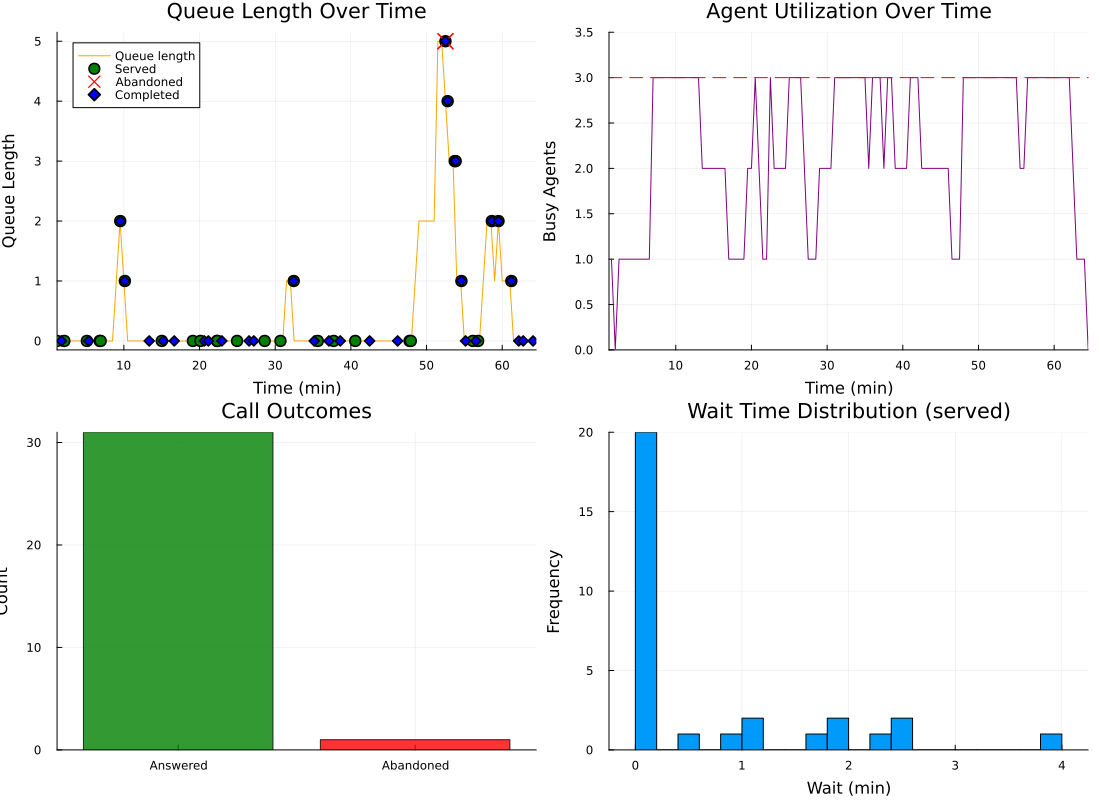

In [14]:
stats, p = run_call_center_simulation(num_agents=3, sim_time=60.0,
                                      mean_interarrival=1.8,
                                      mean_service=5.0,
                                      max_wait=4.0,
                                      rng_seed=123);

=== Call Center Simulation ===
agents: 3, sim_time: 60.0, mean_interarrival: 1.2, mean_service: 5.0, max_wait: 4.0

[61.17] Arrivals stopped. Waiting for system to empty...
[71.00] All customers served/abandoned. Simulation complete.

=== Simulation Results ===
Actual start time: 0.78
Actual end time:   71.00
Total calls:       50
Answered calls:    38 (76.0%)
Abandoned calls:   12 (24.0%)

Mean wait (served): 1.44
Median wait (served): 1.54
Max wait (served): 3.39

Mean service: 4.60

Generating plots...


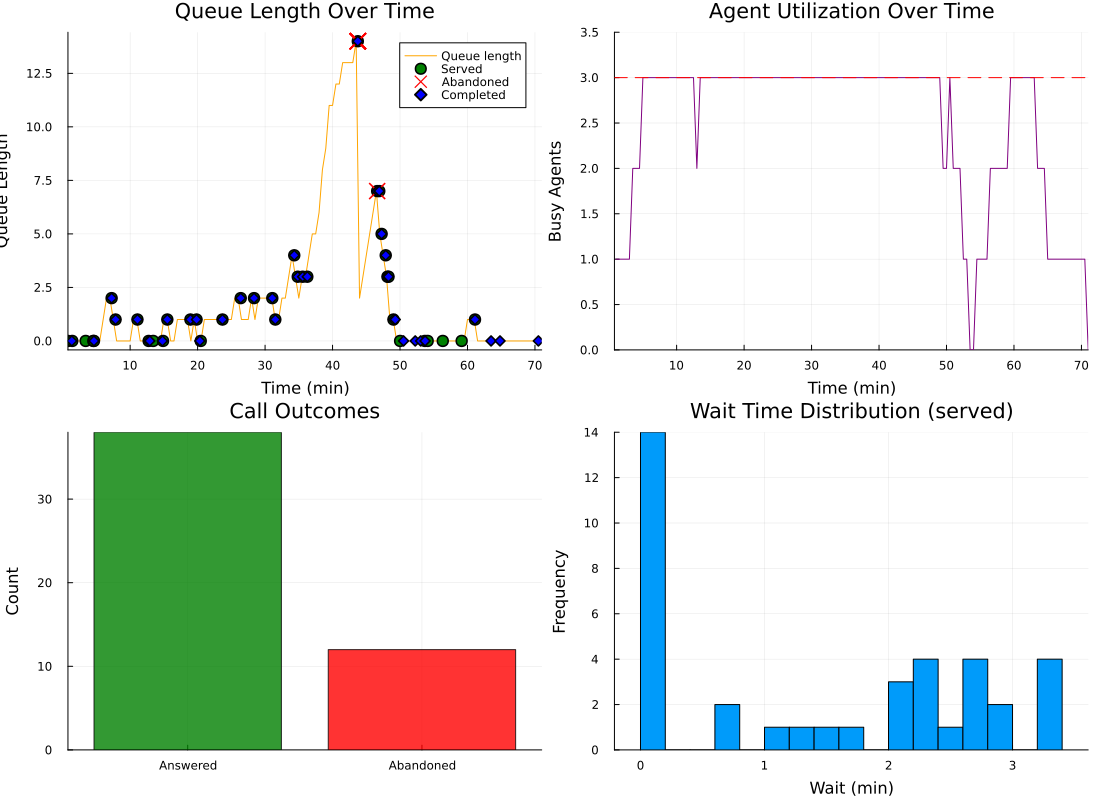

In [15]:
stats, p = run_call_center_simulation(num_agents=3, sim_time=60.0,
                                      mean_interarrival=1.2,
                                      mean_service=5.0,
                                      max_wait=4.0,
                                      rng_seed=123);

=== Call Center Simulation ===
agents: 4, sim_time: 60.0, mean_interarrival: 1.0, mean_service: 5.0, max_wait: 4.0

[60.18] Arrivals stopped. Waiting for system to empty...
[70.00] All customers served/abandoned. Simulation complete.

=== Simulation Results ===
Actual start time: 0.65
Actual end time:   70.00
Total calls:       64
Answered calls:    47 (73.4%)
Abandoned calls:   17 (26.6%)

Mean wait (served): 1.83
Median wait (served): 1.83
Max wait (served): 3.95

Mean service: 5.09

Generating plots...


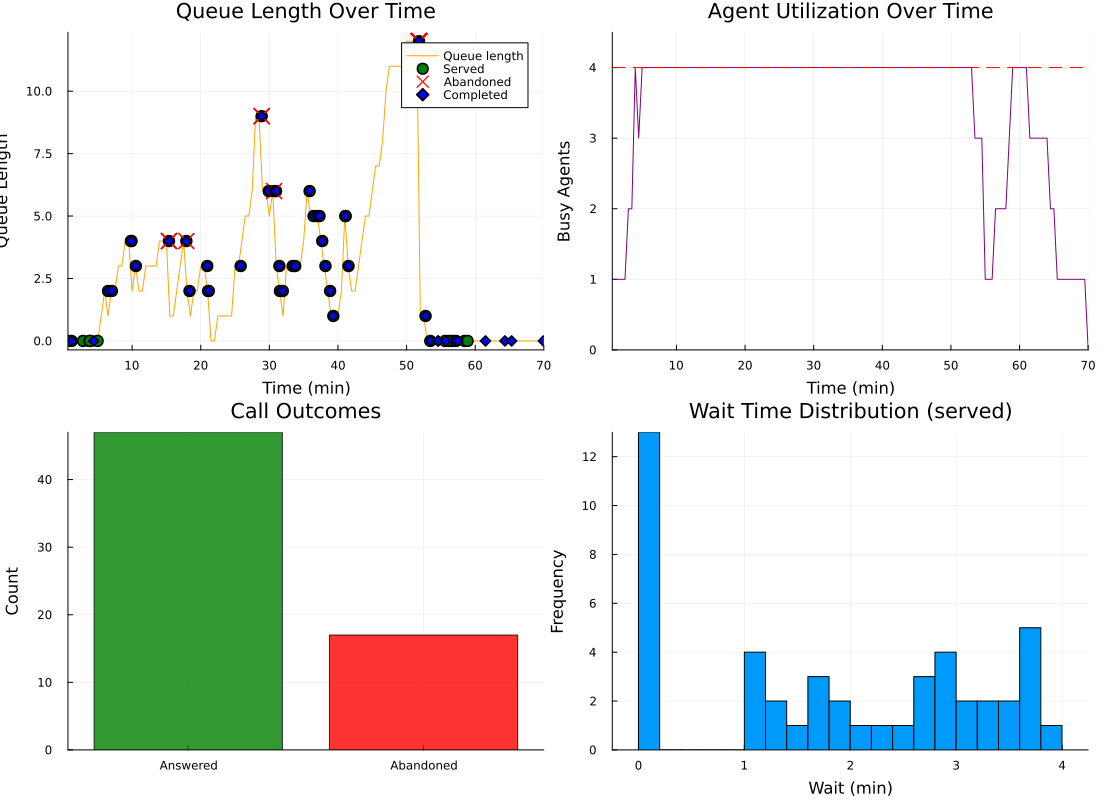

In [16]:
stats, p = run_call_center_simulation(num_agents=4, sim_time=60.0,
                                      mean_interarrival=1.0,
                                      mean_service=5.0,
                                      max_wait=4.0,
                                      rng_seed=123);

=== Call Center Simulation ===
agents: 3, sim_time: 60.0, mean_interarrival: 0.2, mean_service: 5.0, max_wait: 4.0

[60.23] Arrivals stopped. Waiting for system to empty...
[65.50] All customers served/abandoned. Simulation complete.

=== Simulation Results ===
Actual start time: 0.13
Actual end time:   65.50
Total calls:       306
Answered calls:    36 (11.8%)
Abandoned calls:   270 (88.2%)

Mean wait (served): 3.32
Median wait (served): 3.85
Max wait (served): 3.99

Mean service: 5.37

Generating plots...


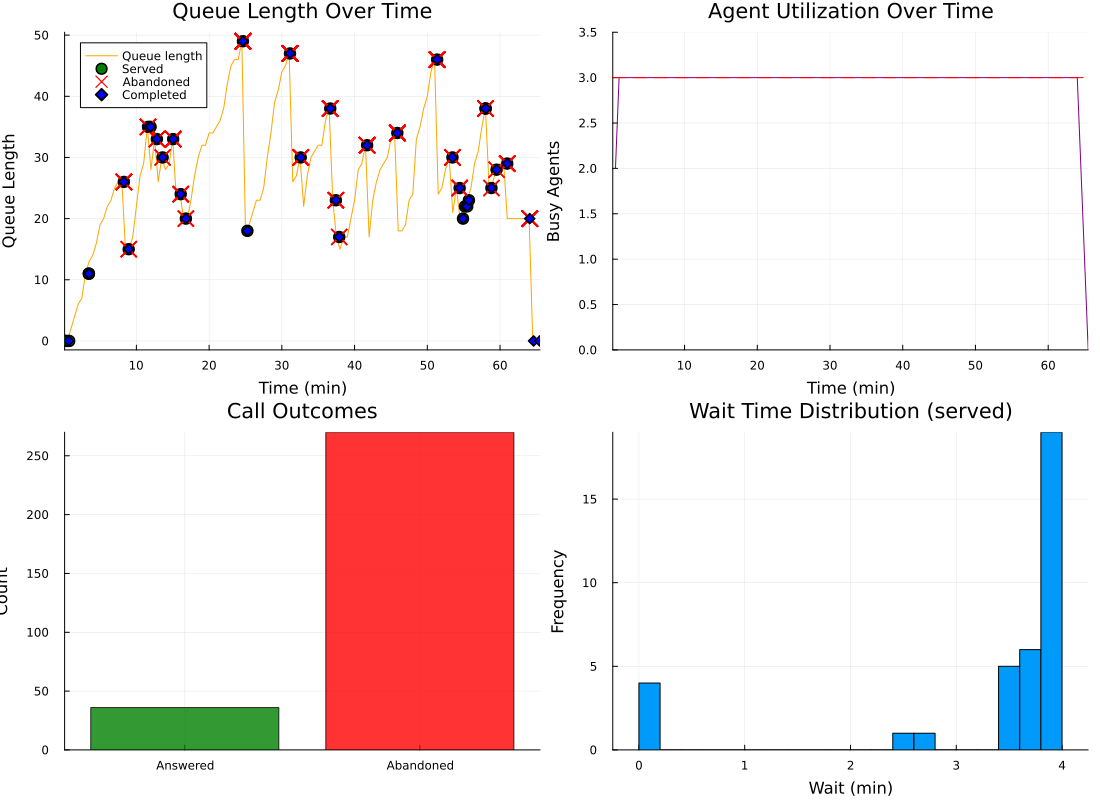

In [17]:
stats, p = run_call_center_simulation(num_agents=3, sim_time=60.0,
                                      mean_interarrival=0.2,
                                      mean_service=5.0,
                                      max_wait=4.0,
                                      rng_seed=123);